In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

# Getting WA ratings

In [13]:
ratings = pd.read_excel('data/ratings.xlsx', index=False, encoding = 'ascii')
#ratings = ratings[ratings['Category']=='Premier cru 1855']
selected_vineyards = list(ratings['Chateau'].unique())
print(selected_vineyards)
#selected_vineyards = ['Château Cheval Blanc', 'Château Ausone', 'Château Angélus', 'Château Trotte Vieille']

ratings['Rating - Avg'] = (ratings['Rating - LB'] + ratings['Rating - HB'])/2
ratings = ratings.groupby('Vintage')['Rating - Avg'].mean().to_frame()
display(ratings.head())

['Château Lafite Rothschild Pauillac', 'Château Latour Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer']


,Rating - Avg
Vintage,
1994,90.50
1995,92.35
1996,92.00
1997,90.15
1998,91.20


## Getting Price

In [14]:
prices = pd.read_excel('data/prices.xlsx', index_col=0)

df = prices.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df = df.replace(-100, np.NaN)
display(df['Chateau'].unique())
selected_prices = df[(df['Chateau'].isin(selected_vineyards))].fillna(method='ffill')
display(selected_prices['Chateau'].unique())
prices = selected_prices.groupby('Vintage')['Price'].mean().to_frame()
display(prices.head())

array(['Château Lafite Rothschild Pauillac', 'Château Latour Pauillac',
       'Château Mouton Rothschild Pauillac', 'Château Margaux',
       'Château Haut-Brion Pessac-léognan',
       'Château Brane-Cantenac Margaux', 'Château Durfort-Vivens Margaux',
       'Château Lascombes Margaux', 'Château Rauzan-Gassies Margaux',
       'Château Rauzan-Ségla Margaux',
       'Château Pichon-Longueville Baron Pauillac',
       'Château Pichon-Longueville Comtesse de Lalande Pauillac',
       "Château Clos d'Estournel Saint-Estèphe",
       'Château Montrose Saint-Estèphe',
       'Château Ducru-Beaucaillou Saint-Julien',
       'Château Gruaud Larose Saint-Julien',
       'Château Léoville Barton Saint-Julien',
       'Château Léoville Las Cases Saint-Julien',
       'Château Léoville Poyferré Saint-Julien', 'Château Ausone',
       'Château Cheval Blanc', 'Château Pavie', 'Château Belair-Monange',
       'Château Figeac', 'Château Magdelaine', 'Château Trotte Vieille',
       'Chateau Beausej

array(['Château Lafite Rothschild Pauillac', 'Château Latour Pauillac',
       'Château Mouton Rothschild Pauillac', 'Château Margaux',
       'Château Haut-Brion Pessac-léognan', 'Château Ausone',
       'Château Cheval Blanc', 'Château Trotte Vieille',
       'Château Angélus', 'Château Palmer'], dtype=object)

,Price
Vintage,
1950,543.0
1951,597.6
1952,263.0
1953,825.0
1954,713.4


In [15]:
X = pd.DataFrame(index = precipitations.index)

X['Winter Rain'] =  precipitations.shift(1)['Dec'] # really important

#X['Square Winter Rain'] =  X['Winter Rain']**2

X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2

#X['Square Harvest Rain'] =  X['Harvest Rain']**2



X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])

#X['Square Winter Temperature'] = X['Winter Temperature']**2

X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

#X['Square Summer Temperature'] = X['Summer Temperature']**2


X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2


#X['Square Harvest Temperature'] = X['Harvest Temperature']**2




#X['Frost Days'] = frost_days['Mar']+ 3*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])

#X['Square Frost Days'] = X['Frost Days']**2

#X['Insulation'] = insulation.iloc[:,0] # negative on mean r2 and bad scores

,Price
Vintage,
1950,543.0
1951,597.6
1952,263.0
1953,825.0
1954,713.4


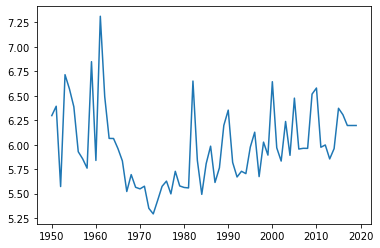

In [16]:
display(prices.head())
y = prices
y['Log Price'] = np.log(y['Price'])
sns.lineplot(data=y['Log Price'])
plt.show()

In [17]:
def classifier(prices, key, window_size, horizon=3, n_categories=4):
    for vintage in prices.index:
        window = prices.loc[(vintage-horizon-window_size):(vintage-horizon), 'Log Price']
        window.loc[vintage] = prices.loc[vintage, key]
        prices.loc[vintage, key+' Class'] = pd.qcut(window, n_categories,labels=False, duplicates='drop').iloc[-1]
    prices[key+' Class'] = prices[key+' Class'].fillna(1).astype(int)
    return prices

display(classifier(y, 'Log Price',3).head())

,Price,Log Price,Log Price Class
Vintage,,,
1950,543.0,6.297109,1
1951,597.6,6.392922,1
1952,263.0,5.572154,1
1953,825.0,6.715383,3
1954,713.4,6.570042,3


# Implementing Kalman Filter

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

def Kalman(X,y):
    """Filters observations Y based on weather values X"""
    X = X.reset_index(drop=True)
    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)
    
    column_names = X.columns.to_list()+['Intercept']
    coefficients = pd.DataFrame(0, index=y.index, columns=column_names)

    x_k = np.array([0]*(len(column_names)-1)+[6]).reshape(-1,1)
    print(np.shape(x_k))
    
    dimension_x = len(X.columns)+1
    
    #initialise the real state's covariant matrix
    P_k = np.eye(dimension_x)*1
    
    # Initialize the covariance matrix of random real state perturbations
    Q = np.eye(dimension_x)*1
    Q[dimension_x-1,dimension_x-1] = 1
    print(Q)
    
    
    # Initialize the covariance matrix of observation noise, here in dimension 1
    R = 1
    predictions = []
    len_buffer = 10
    buffer = [np.zeros_like(x_k)] * len_buffer
    
    min_vintage = y.index[0]
    y['Predicted Log Price']=0

    for vintage in y.index.to_list(): #for each observed value
        
        #Do one step
        H_k = np.array(X.iloc[vintage-min_vintage, :].values.tolist()+[1]).reshape(1,-1)
        
        a, b = 0,10
        coeffs = [0]*(len_buffer)
        total = sum([a*j+b for j in range(len_buffer-3)])
        for i in range(len_buffer-3):
            coeffs[i] = (a*i + b)/ total
        buffered_x_k = sum([buffer[i]*coeffs[i] for i in range(len_buffer)])
        y.loc[vintage, 'Predicted Log Price'] = (H_k @ buffered_x_k)[0,0]
        
        P_k = P_k + Q
        
        # Computing Kalman gain, i.e. the learning rate
        K = P_k @ H_k.T * (1/(H_k @ P_k @ H_k.T + R))

        # Variable update
        x_k = x_k + (K * (y.loc[vintage, 'Log Price'] - H_k @ x_k))*0.8
        buffer = buffer[1:] + [x_k]
              
        for i in range(len(column_names)):
            coefficients.loc[vintage, column_names[i]]=x_k[i]
        

        P_k = P_k - (K @ H_k @ P_k)
    return y, coefficients
        
y_ex = y.loc[1950:2013][['Log Price']]
X_ex = X.loc[1950:2013,:]
y_result, coefficients = Kalman(X_ex, y_ex)
actual_prices = y_result.loc[1950:2013,'Log Price']
display(y_result['Predicted Log Price'])

print(r2_score(actual_prices[-40:], y_result['Predicted Log Price'][-40:]))

(6, 1)
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


Vintage
1950    0.000000
1951    0.000000
1952    0.000000
1953    0.000000
1954    0.862956
          ...   
2009    6.285884
2010    6.336266
2011    6.182994
2012    6.359978
2013    5.821090
Name: Predicted Log Price, Length: 64, dtype: float64

0.4479291879473162


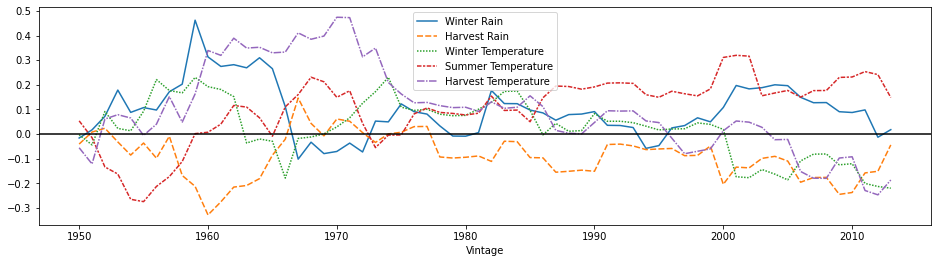

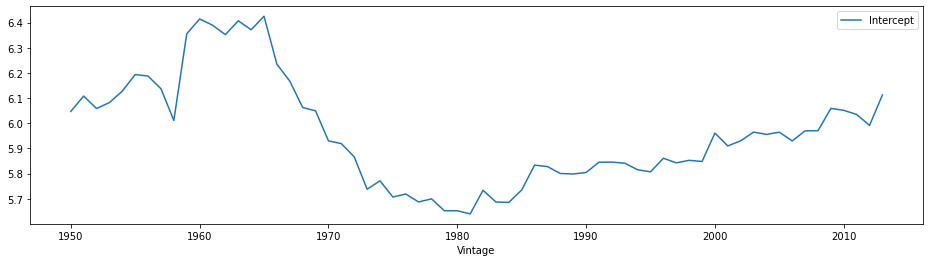

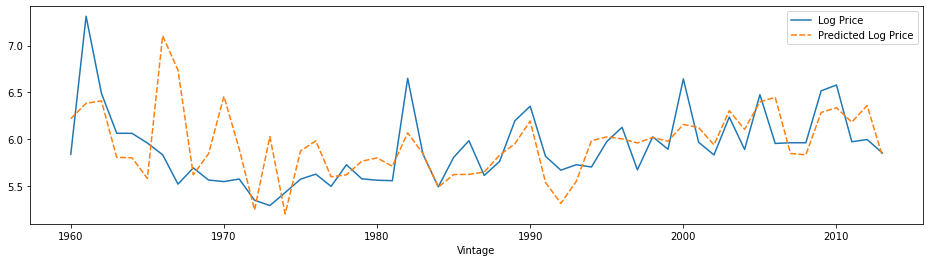

['1975-1985', '1976-1986', '1977-1987', '1978-1988', '1979-1989', '1980-1990', '1981-1991', '1982-1992', '1983-1993', '1984-1994', '1985-1995', '1986-1996', '1987-1997', '1988-1998', '1989-1999', '1990-2000', '1991-2001', '1992-2002', '1993-2003', '1994-2004', '1995-2005', '1996-2006', '1997-2007', '1998-2008', '1999-2009', '2000-2010', '2001-2011', '2002-2012', '2003-2013', '2004-2014']


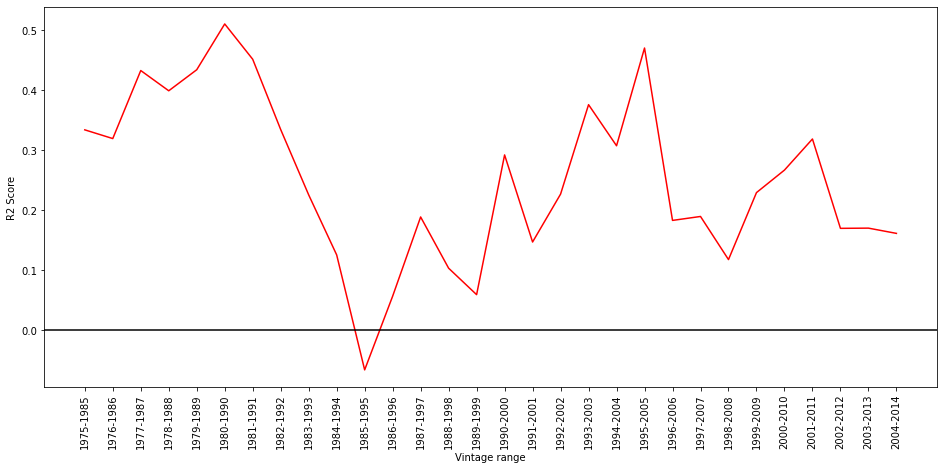

0.25085337831950094
0


In [19]:
import seaborn as sns

plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.drop('Intercept', axis=1)).axhline(0., color='black')
plt.savefig('views/coefficients.png', bbox_inches='tight')

plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients[['Intercept']])
plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=y_result.loc[1960:2015,['Log Price', 'Predicted Log Price']])
plt.savefig('views/prediction_v_true.png', bbox_inches='tight')
plt.show()

r2_scores=[]
for i in range(1950,2005):
    r2_scores.append(r2_score(y_result.loc[i:(i+10), 'Log Price'],y_result.loc[i:(i+10), 'Predicted Log Price']))
    
    
labels = [str(i)+'-'+str(i+10) for i in range(1975,2005)]
print(labels)
plt.figure(figsize=(16,7))
sns.lineplot(x=range(30), y=r2_scores[-30:], color='red').axhline(0., color='black')
plt.xticks(range(30),labels=labels, rotation=90)
plt.xlabel('Vintage range')
plt.ylabel('R2 Score')
plt.savefig('views/r2_scores.png', bbox_inches='tight')
plt.show()

sel_scores = r2_scores[-30:]
bad_scores = 0
for score in sel_scores:
    if score < -0.1:
        bad_scores+=1
    if score < -0.2:
        bad_scores+=1
    if score < -0.3:
        bad_scores+=1
        
print(np.mean(sel_scores))
print(bad_scores)

Best average R2, all parameters: 0.287 for buffer 10, R=25.


Best average R2, without the squares: 0.299 for buffer 10, R=1, without any coefficient weighting.



We managed to improve over the results of the regression with the Kalman filter, which acts like a decaying memory. Now, classifying the results will give new results. Two options are possible when categorizing the 'Predicted Log Price' column: ranking it amongst the other 'Predicted Log Price' or against the 'Log Price'.
Second options makes accuracy go from 0.29 to 0.47

# Final step: model vs Robert Parker

### Bucket metrics

The variation of prices will not be easy to predict based on our limited variables. Instead, we choose to classify wines into 3 categories: Good, Average, Bad. These categories will be based on the position of the wines compared to the previous decade of production: if a vintage ranks in the top quartile of the window [vintage -horizon -10 years, vintage -horizon years], it will be Very Good, 50-75% quartile will be Good, and so on.

In [20]:
from sklearn.metrics import accuracy_score

n_categories = 4
y_rp = y_result.loc[1994:2018,:]
#y_rp = y_rp.loc[1994:2018,:]

y_rp['Predicted Log Price Class'] = pd.qcut(y_rp['Predicted Log Price'], n_categories, labels=False, duplicates='drop')
y_rp['Log Price Class'] = pd.qcut(y_rp['Log Price'], n_categories, labels=False, duplicates='drop')
y_rp['Rating Class'] = pd.qcut(ratings['Rating - Avg'], n_categories, labels=False, duplicates='drop')
display(y_rp)
print('Accuracy of model predictions: ',accuracy_score(y_rp['Predicted Log Price Class'], y_rp['Log Price Class']).round(3))
print("Accuracy of WA ratings: ",accuracy_score(y_rp['Rating Class'], y_rp['Log Price Class']).round(3))
print('Accuracy of model predicting WA rating: ',accuracy_score(y_rp['Predicted Log Price Class'], y_rp['Rating Class']).round(3))
#print('Average error: ', np.mean(np.abs(y_result.loc[1990:2010, 'Predicted Log Price Class'] - y_result.loc[1990:2010, 'Log Price Class'])))

<ipython-input-20-516c10b1ef4e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_rp['Predicted Log Price Class'] = pd.qcut(y_rp['Predicted Log Price'], n_categories, labels=False, duplicates='drop')
<ipython-input-20-516c10b1ef4e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_rp['Log Price Class'] = pd.qcut(y_rp['Log Price'], n_categories, labels=False, duplicates='drop')
<ipython-input-20-516c10b1ef4e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,Log Price,Predicted Log Price,Predicted Log Price Class,Log Price Class,Rating Class
Vintage,,,,,
1994,5.704116,5.984392,1,0,0
1995,5.975081,6.025769,1,2,1
1996,6.127524,6.004230,1,2,1
1997,5.673667,5.960251,0,0,0
1998,6.026107,6.019737,1,2,0
1999,5.893300,5.978795,1,1,0
2000,6.643660,6.157951,2,3,2
2001,5.967684,6.125347,2,1,0
2002,5.832469,5.940138,0,0,1


Accuracy of model predictions:  0.4
Accuracy of WA ratings:  0.4
Accuracy of model predicting WA rating:  0.4


We have achieved great precision with only a basic level of tuning! This method of prediction seems to have great potential.

### Spearman correlation in the 10-year window

In [21]:
from scipy.stats import spearmanr

y_rp = y_rp.loc[1994:2013,:]
y_rp['Rating'] = ratings['Rating - Avg']
display(y_rp)
print('Spearman correlation of model predictions: ',spearmanr(y_rp['Predicted Log Price'], y_rp['Log Price'])[0].round(3))
print("Spearman correlation of WA ratings: ",spearmanr(y_rp['Rating'], y_rp['Log Price'])[0].round(3))
print('Spearman correlation of model predicting WA rating: ',spearmanr(y_rp['Predicted Log Price'], y_rp['Rating'])[0].round(3))

,Log Price,Predicted Log Price,Predicted Log Price Class,Log Price Class,Rating Class,Rating
Vintage,,,,,,
1994,5.704116,5.984392,1,0,0,90.50
1995,5.975081,6.025769,1,2,1,92.35
1996,6.127524,6.004230,1,2,1,92.00
1997,5.673667,5.960251,0,0,0,90.15
1998,6.026107,6.019737,1,2,0,91.20
1999,5.893300,5.978795,1,1,0,91.80
2000,6.643660,6.157951,2,3,2,95.85
2001,5.967684,6.125347,2,1,0,91.85
2002,5.832469,5.940138,0,0,1,93.20


Spearman correlation of model predictions:  0.617
Spearman correlation of WA ratings:  0.699
Spearman correlation of model predicting WA rating:  0.668


# Appendix: Training a decision tree

[array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([3]), array([3]), array([2]), array([2]), array([1]), array([3]), array([1]), array([3]), array([1]), array([0]), array([3]), array([2]), array([2]), array([3]), array([3]), array([0]), array([3]), array([0]), array([3]), array([0]), array([0]), array([1]), array([1]), array([1]), array([3]), array([3]), array([0]), array([3]), array([2]), array([2]), array([1]), array([0]), array([1]), array([2]), array([0]), array([3]), array([1]), array([0]), array([0]), array([0])]


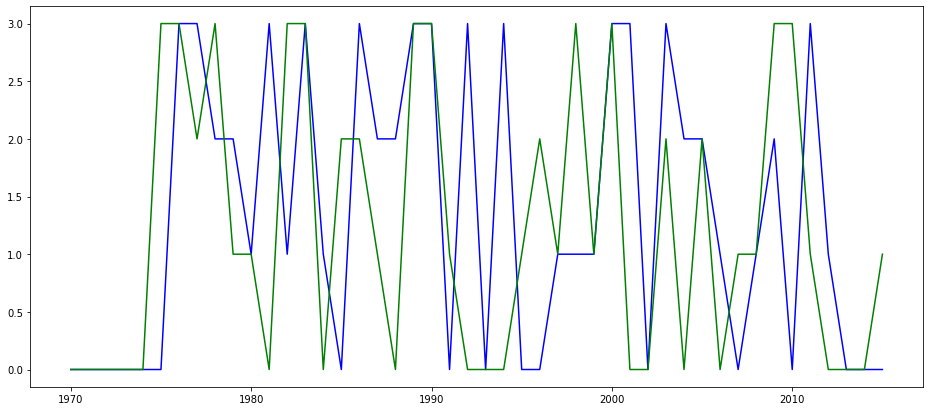

In [8]:
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
y = classifier(y, 'Log Price', 3)

def model_predict(X,y, window_length, model):
    predictions = []

    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for target_vintage in range(1950+window_length,2016):
        oldest_vintage = target_vintage-window_length
        newest_vintage = target_vintage

        y_ex = y.loc[oldest_vintage:newest_vintage-1,'Log Price Class'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage-1,:].reset_index()

        target = X.loc[target_vintage,:]
        model.fit(X_ex,y_ex)
        
        target = np.array([target_vintage]+target.to_list()).reshape(1,-1)
        prediction = model.predict(target)
        predictions.append(prediction)
    return predictions
    
window_length = 20
plt.figure(figsize=(16,7))

predictions = model_predict(X,y, window_length, model)
print(predictions)
plt.plot(range(1950+window_length,2016), predictions, color='blue')
sns.lineplot(data=y.loc[1950+window_length:2015,'Log Price Class'], color='green')
plt.show()

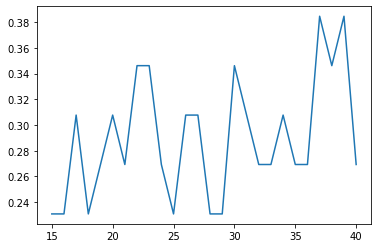

Maximal score:  0.38461538461538464


In [9]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

scores=[]
other_scores=[]

for window_length in range(15,41,1):
    model = DecisionTreeClassifier()
    prediction = model_predict(X,y, window_length, model)
    prediction = prediction[-26:]
    actual_classes = y.loc[1990:2015,'Log Price Class'].values
    scores.append(accuracy_score(actual_classes, prediction))
    
plt.plot(range(15,41,1),scores)
plt.show()
print('Maximal score: ',max(scores))